# New Try
The other methods of displacement finding weren't so nice. So this time let's try by first finding the ROI we need as well as all the ROIs that surround it


# The Problem with this approach. 
Now, we are able to find the vertexes of th required cell segmentation very easily. This is because the ROI of every cell <i> includes </i> the cell walls. However, this is not exactly correct I feel. This also leads to alot more errors occuring.

OK. Lets think about this another way. Hmmm.... maybe, just maybe, if I just use different algorithms to alter the image before the machine learning process, then maybe this could work. 



In [87]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread
from pathlib import Path
import os
from Modules import specificOutline, getFileDir, getOutlines, smoother, splitImg, plotSide # Custom module for readability
import Modules_Displacement # custom module for readability
import Modules
from PIL import Image

# List of Files
# Importing all the files

# the folder containing the .npy and png (or .tif files) are stored 
npyDir = "Haltere" # CHANGE THIS
cellTypeName = npyDir
cellTypePlot = cellTypeName + "Plots"
numOfClusters = 15 # 8 for haltere

# Makes the directy to point to the seg files
basedir = os.path.join(Path.cwd(), npyDir)
files = io.get_image_files(basedir, "")
dir = []
for f in files: 
    dir.append((os.path.join(basedir, f) + "_seg.npy").replace(".tif", ""))
dir = dir

In [88]:
# stepsize = (0.823 - 0.549)/2

# tempX = np.arange(0.549, stepsize * 100, stepsize).tolist()

# bigX = [ 0.549/3 * i for i in range(3)]
# bigX = bigX + tempX
# len(bigX)

In [89]:
roi_name = [] # a list containing the name of the roi we need

for i in range(len(dir)):  
    dat = np.load(dir[i], allow_pickle=True).item()
    masks = dat['masks'] # Using the masks gives us a larger target to select from than outlines
    filenam = dat['filename']
    width, height = masks.shape
    neededROI = masks[width//2][height//2] # the general area of where our ROI will always be
    # the below code saves the outline in an image file
    if neededROI != 0: 
        roi_name.append([i, neededROI])

# Method
The thought process for this method is that the cell we want will be boreder by other cells. However, the vertexes of those cells will be bordered by 3 cells. The cell we want, and two other cells. 

The "outlines" part of the .npy files contains the outlines for a particular cell. By iterating through this 2D array, we can obtain the coordinates for the border of the cell we are interested in. Now for each of these coordinates, we can create a 3 x 3 sized 2D matrix subarray where the coordinate we input is the center. This will give us the coordinates for the vertexes


In [90]:
# function to find the vertexes. 
# works by looking at the items surround i, j 
# filters out so only the unique items are found
# if it is bordered by more than 3 unique items, then it is a vertex point
# Check 
def findVertex(masks, j, i, k = 2):  
    surr =[masks.item((j+k, i-k)),
    masks.item((j+k, i)),
    masks.item((j+k, i+k)),
    masks.item((j, i-k)),
    masks.item((j, i)),
    masks.item((j, i+k)),
    masks.item((j-k, i-k)),
    masks.item((j-k, i)),
    masks.item((j-k, i+k))]
    # the set() function returns the unique values of the array. If the size of the list is more than
    # 2, then we can return j, i. As this means that it is bordered by at least 3 cells
    if len(list(set(surr)))>2: 
        return [j, i]

def dist(f, g): # displacement 
    return np.sqrt((f[0] - g[0])**2 + (f[1] - g[1])**2)

def dist2(ListOfSpecificVertex, i): 
    return np.sqrt[dist(ListOfSpecificVertex[0], ListOfSpecificVertex[i])] # Gets you the T0 - T(n)    

What we can do now, is repeat the above function for two different points, and see what happens for the one above and below 

In [91]:
M = [] # list containing all the masks
O = [] # list containing all the outlines

for k in range(len(roi_name)): 
    # Get the file number, and the roi of the cell we are interested in
    num, roi = roi_name[k]
    dat = np.load(dir[num], allow_pickle=True).item()
    masks = dat['masks']
    outlines = dat['outlines']

    # Get the masks and the outlines of the cell we are interested in
    # M.append(specificOutline(masks, roi)) # list containing all the masks
    M.append(masks)
    O.append(specificOutline(outlines, roi)) # list containing all the outlines
    
pointsList = []

for k in range(len(M)): 
    points = []
    o = O[k]
    height, width = o.shape
    # iterate through the matrix and get the coordinates that make up the outline
    # of the cell we are interested in
    for i in range(height): 
        for j in range(width): 
            if o[i][j] != 0: 
                points.append([j, i])
    # points is now a list which contains the coordinates for each point that matters for our outline
    # store the vertexes for file number k in the array
    pointsList.append(points)

# plt.imshow(O[5])
# plt.imshow(M[5])

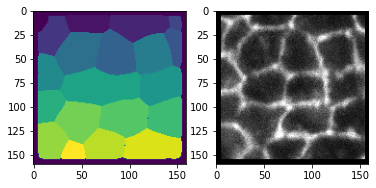

In [92]:
plotSide(M[3],Image.open(files[0]))

In [93]:
mainVertexList = []
for q in range(len(roi_name)): 
    points = pointsList[q] # specific set of points

    X = np.array(pointsList[q])[:, 0]
    Y = np.array(pointsList[q])[:, 1]

    vertexes = []
    for k in range(len(points)): 
        i, j = points[k]
        vert = findVertex(masks, j, i) # This finds if a particular point is a vertex or not
        if vert: 
            vertexes.append(vert)
    # Group similar vertexes
    masterList = []
    count = 0
    tempVertex = []
    mainVertexList.append(vertexes)

    for i in range(len(vertexes)): 
        masterListTemp = []
        if i not in masterList: 
            masterListTemp.append(i)
            commonVertexes = []
            # distval = 1: 
            # while distval < 50 or len(tempVertex) == 11: 
            for j in range(len(vertexes)): 
                if i != j and j not in masterList: 
                    if dist(vertexes[i], vertexes[j]) < 5: 
                        tempVertex.append(j)
                        masterList.append(j)
        count += 1

In [94]:
stepsize = (0.823 - 0.549)/2

tempX = np.arange(0.549, stepsize * 100, stepsize).tolist()

bigX = [ 0.549/3 * i for i in range(3)]
bigX = bigX + tempX
len(bigX)

99

In [95]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy
from sklearn.cluster import KMeans
import pandas as pd

count = 0 
for i in mainVertexList:  
    count += 1
    if len(i) < 2: 
        mainVertexList.pop(count)

# change num of clusters manually 

kmeans = KMeans(n_clusters= numOfClusters, random_state=42) 
a = []
x = []
for i in range(len(mainVertexList)): 
    X = mainVertexList[i]
    if len(X) > 1: 
        clusts = kmeans.fit_predict(X)
        df = pd.DataFrame(X)
        df["labels"] = clusts
        df["frame"] = i 
        x.append(df)

ValueError: n_samples=14 should be >= n_clusters=15.

In [ ]:
count = 0 
for i in mainVertexList: 
    if len(i) < 2: 
        print(i)

[]


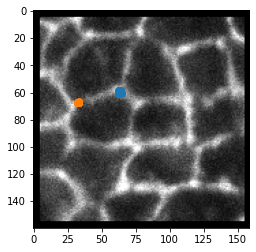

In [96]:
# # I need to relabel the clusters so that it looks nice enough hahahaha
allx = pd.concat(x)
# plt.scatter(allx[1], allx[0])
C = list(zip(allx[1], allx[0]))
clusts = kmeans.fit_predict(C)

allx["clusterNum"] = clusts

clus1 = allx.loc[allx["clusterNum"] == 6]
clus2 = allx.loc[allx["clusterNum"] == 0]
f, ax = plt.subplots()
ax.scatter(clus1[1], clus1[0])
ax.scatter(clus2[1], clus2[0])
df = pd.DataFrame(X)
plt.imshow(Image.open(files[0]))


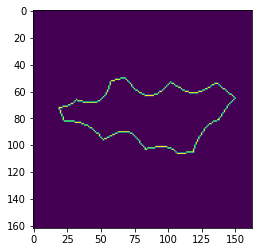

In [31]:
X1 = np.array(clus1[0])
X2 = np.array(clus2[0])
Y1 = np.array(clus1[0])
Y2 = np.array(clus2[0])

displacement = np.sqrt((Y2 - Y1)**2 + (X2- X1)**2)


ValueError: operands could not be broadcast together with shapes (116,) (68,) 

116

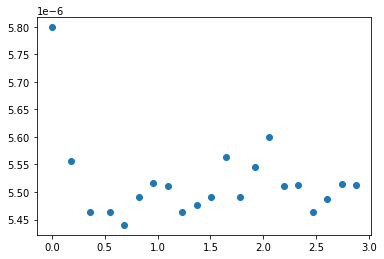

In [14]:
plt.scatter(bigX, bigY)


In [15]:
displacementlist = []
bigX = []
bigY = []
nY = []
avgVertex = []
for i in range(len(mainVertexList)): 
    b = allx.loc[allx["frame"] == i]
    a = b.loc[b["clusts2"] == k] # gives us the clusters for the frame and the cluster number
    # plt.scatter(a[1], a[0])
    if len(a) !=0: 
        avgA = [np.sum(a[1])/len(a[1]), np.sum(a[0])/len(a[0])]
    # plt.scatter(avgA[1], avgA[0])
        avgVertex.append(avgA)
    else: 
        print("wut", i)

avgVertex = compVertex
displacementlist = []

for i in range(len(avgVertex)): 
    displacementlist.append(dist(avgVertex[0], avgVertex[i]))

pixelToScale = 1/7.5879 * 10**(-6)
bigY = np.array(displacementlist) * pixelToScale

bigX = 0 

tempX = np.arange(0.549, stepsize * (len(bigY)  + 2), stepsize).tolist()
bigX = [ 0.549/3 * i for i in range(3)]
bigX = bigX + tempX

while len(bigX) != len(bigY): 
    bigX.pop(-1)

def expon(t, a, b, c): 
    return a*t**b 
A = scipy.optimize.curve_fit(expon,  bigX,  bigY)
a, b, c = A[0]
nY = []
for i in bigX:
    nY.append(expon(i, a, b, c))

import scipy.optimize

A = scipy.optimize.curve_fit(expon,  bigX,  bigY)

a, b, c = A[0]
nY = []
for i in bigX:
    nY.append(expon(i, a, b, c))


plt.clf()
plt.plot(bigX, nY)
# plt.scatter(bigX, bigY)

plt.suptitle(cellTypeName)
plt.title("Composite of All " )
plt.xlabel("Time (s)")
plt.ylabel("displacement " + r'($\mu$m)')
savedir = Path.joinpath(Path.cwd(), cellTypePlot)
imgdir = str(savedir) + "\Composite.png"

plt.savefig(imgdir)

wut 1
wut 7
wut 13


NameError: name 'compVertex' is not defined

In [ ]:
displacementlist[0]

0.0

In [ ]:
# coeffs = numpy.polyfit(bigX, bigY, deg=5)
# poly = numpy.poly1d(coeffs)

# plt.plot(bigX, poly(bigX))
# plt.scatter(bigX, bigY)
# plt.title("Cluster " + str(k))
# plt.xlabel("Time (s)")
# plt.ylabel("displacement " + r'($\mu$m)')

In [ ]:
# def filterVertex(points, masks, distVal = 5): 
#     vertexes = []
#     for k in range(len(points)): 
#         i, j = points[k]
#         vert = findVertex(masks, j, i)
#         if vert: 
#             vertexes.append(vert)
#     # now in the vertexes file, there are some points which are overlapping with others
#     # in order to fix this, we can remove the points in the vertex file which are close to
#     # each other. 
    
#     vertexes = np.array(vertexes)

#     for i in range(len(vertexes)): 
#         if len(vertexes[i]) > 1: 
#             a, b = vertexes[i]
#             for j in range(len(vertexes)): 
#                 if i != j: 
#                     c, d = vertexes[j]
#                     dist = np.sqrt((a - c)**2 + (b - d)**2) # displacement formula
#                     if dist < distVal: # distval determines the max distance between vertexes
#                         vertexes[j] = -1 # setting those values as -1

#     # now we filter out the entries with -1, giving us the values we require
#     vert2 = []
#     for i in range(len(vertexes)): 
#         if vertexes[i][0] > 0: 
#             vert2.append(vertexes[i])
#     return vert2

In [ ]:
# pointsList = []

# for k in range(len(M)): 
#     points = []
#     o = O[k]
#     height, width = o.shape
#     # iterate through the matrix and get the coordinates that make up the outline
#     # of the cell we are interested in
#     for i in range(height): 
#         for j in range(width): 
#             if o[i][j] != 0: 
#                 points.append([j, i])
#     # points is now a list which contains the coordinates for each point that matters for our outline
#     # store the vertexes for file number k in the array
#     pointsList.append(points)

In [ ]:
# # code ensures each image has the same number of vertexes
# # now we get the vertexes for each file, and we get the lengths for each file as well

# vertexList = []
# lengths = []
# for k in range(len(pointsList)): 
#     possibleVertex = filterVertex(pointsList[k], M[k])
#     if len(possibleVertex) == 11: 
#         vertexList.append(possibleVertex)
#         lengths.append(len(possibleVertex))
#     else: 
#         for i in range(50): 
#             possibleVertex = filterVertex(pointsList[k], M[k], distVal= i* 0.2)
#             if len(possibleVertex) == 11: 
#                 vertexList.append(possibleVertex)
#                 lengths.append(len(possibleVertex))
#                 break 
# print(len(lengths))

In [ ]:
# # Attempt for getting displacement

# def dist(f, g): 
#     return np.sqrt((f[0] - g[0])**2 + (f[1] - g[1])**2)
# displacementList = [[] ]* (len(vertexList) - 1)

# for k in range(len(vertexList) - 1): 
#     displacement =[]
#     v1 = vertexList[k]
#     v2 = vertexList[k + 1]
#     for j in range(len(v1)): 
#         f = v1[j]
#         potentialDist = 100
#         for h in range(len(v2)): 
#                 g = v2[h]
#                 dtest = dist(f, g) # iterate through and find which ones have the small displacement
#                 if dtest < potentialDist: 
#                     potentialDist = dtest
#         displacement.append(potentialDist)
#     displacementList[k] = displacement

In [ ]:
# A = []
# mainlist = []
# NewPointsList = []

# i = 0
# # for i in range(len([1])): 
#     # if i not in mainlist:
#     #     mainlist.append(i)
#     #     mainlist.append(i + 1)

#     # a list of points for a specific outline

# for i in range(len(VlistF)):
#     A = VlistF[i] # Getting the vertexes for a specific file
#     NewPointsList = []
#     for k in range(len(A)):
#         a = A[k]
#         a = np.array(a)
#         G = [np.average(a[:, 0]), np.average(a[:, 1])]
#         NewPointsList.append(G)
#     mainlist.append(NewPointsList)


In [ ]:
# k = 65

# X1 = np.array(mainlist[k])

# x = X1[:, 0]
# y = X1[:, 1]

# plt.scatter(y, x)
# plt.imshow(O[k])

In [ ]:
# mainlist[0]
# print(mainlist[0])
# print(mainlist[1])

# vertexList = mainlist

In [ ]:
# code ensures each image has the same number of vertexes
# now we get the vertexes for each file, and we get the lengths for each file as well
# lengths = []

# for k in range(len(pointsList)): 
#     possibleVertex = filterVertex(pointsList[k], M[k])
#     if len(possibleVertex) == 11: 
#         vertexList.append(possibleVertex)
#         lengths.append(len(possibleVertex))
#     else: 
#         for i in range(10): 
#             possibleVertex = filterVertex(pointsList[k], M[k], distVal=i)
#             if len(possibleVertex) == 11: 
#                 vertexList.append(possibleVertex)
#                 lengths.append(len(possibleVertex))
#                 break

In [ ]:
# # Attempt for getting displacement

# def dist(f, g): 
#     return np.sqrt((f[0] - g[0])**2 + (f[1] - g[1])**2)
# displacementList = [[] ]* (len(vertexList) - 1)

# for k in range(len(vertexList) - 1): 
#     displacement =[]
#     v1 = vertexList[k]
#     v2 = vertexList[k + 1]
#     for j in range(len(v1)): 
#         f = v1[j]
#         potentialDist = 100
#         for h in range(len(v2)): 
#                 g = v2[h]
#                 dtest = dist2(f, g) # iterate through and find which ones have the small displacement
#                 if dtest < potentialDist: 
#                     potentialDist = dtest
#         displacement.append(potentialDist)
#     displacementList[k] = displacement

In [ ]:
# D = np.asarray(displacementList, dtype = "object")

# Problems with this
this method provides much better vertex detetection than the others for sure, but as the lists are created using the append method, there is no way to tell in which direction they are appended. The position of the vertexes may change after ablation, hence the order in which they are appended may change as well. To counteract this, we can take every entry in "vertexList" and compare it with the next entry in vertexList and see which element will have the least displacement. We can then just interchange those points

In [ ]:
# # for i in range(len(vertexList) - 1):

# i = 0 

# A= np.asarray(vertexList[i])
# B = np.asarray(vertexList[i + 1])
# C = B - A
# print(C[i])
# D = []
# for i in range(len(C)): 
#     if C[i][0] + C[i][1] != 0: # now we have the points that we need
#         D.append([i, C[i]])
# small = 0


In [ ]:
# c = []
# for value in range(80):
#     x = np.asarray(vertexList[value])[:, 0]
#     y = np.asarray(vertexList[value])[:, 1]
#     # plt.scatter(y[0], x[0], marker = "x", color = "red")
#     c.append(list(zip(x, y)))
# c[0]

In [ ]:
# vert = []
# for i in range(len(displacementList)): 
#     vert.append(displacementList[i][1])


In [ ]:
# X = np.arange(0, len(displacementList), 1 )
# plt.scatter(X, vert)
# Y = []

# for i in vert: 
#     if i < 5: 
#         Y.append(i)

# X = np.arange(0, len(Y), 1)

# cummulation =  [Y[0]]
# for i in range(1,len(Y)): 
#     cummulation.append(Y[i] + cummulation[i - 1]) 

# plt.scatter(X, cummulation)

In [ ]:

# v = 5

# for value in range(88):
#     x = np.asarray(vertexList[value])[:, 0]
#     y = np.asarray(vertexList[value])[:, 1]

#     plt.scatter(y, x, marker = "x", color = "red")

# plt.imshow(O[10])

